In [1]:
import numpy as np
import EvaluateModel
import FeatureExtract
import pandas as pd
import parselmouth
import librosa
import matplotlib.pyplot as plt
import os
import preprocessing
import soundfile
import math
import pickle
from sklearn import metrics

In [2]:
def get_noise_from_sound(signal,noise,SNR):
    RMS_s=math.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    #current RMS of noise
    RMS_n_current=math.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    
    return noise

In [3]:
def extract_feature_df(filepath, start=0):
    feat_df = pd.DataFrame()
    for file in os.listdir(filepath):
        filename = os.fsdecode(file)
        if filename.endswith(".wav"):
            y, sr = librosa.load(filepath+filename)
            dur = librosa.get_duration(y=y, sr=sr)
            f_id = filename.split('.')[0]
            path = filepath+file
            report = FeatureExtract.get_report(path, start=start, end=dur)
            feats = FeatureExtract.get_feats(report, f_id)
            feat_df = pd.concat([feat_df, feats])
    return feat_df

In [4]:
path = 'TestSetPrepped//'

In [5]:
test_meta = pd.read_csv('testSet.csv', index_col=0)

In [6]:
clf = pickle.load(open('RF2.sav', 'rb'))

In [7]:
rf_accs={}
rf_precs={}
rf_recalls={}
accs=[]
precs=[]
recalls=[]
for snr in range(5, 55, 5):
    #save noisy files
    for i in range(10):
        save_path = 'NoisyLevels//TestNoisySNR'+str(snr)+'//'
        for file in os.listdir(path):
            filename = os.fsdecode(file)
            if filename.endswith(".mp3") or filename.endswith(".wav"):
                f_id = filename.split('.')[0]
                file_type = filename.split('.')[-1]
                y, sr = librosa.load(path+filename)
                noise=np.random.normal(0, 0.1, y.shape[0])
                noise = get_noise_from_sound(y,noise,snr)
                y_noisy = y+noise

                y_noisy = preprocessing.endpoint_detection(y_noisy)
                y_noisy = preprocessing.normalization(y_noisy)

                soundfile.write(save_path+filename, y_noisy, sr)

        #extract features
        test_df = extract_feature_df(save_path) 
        test_df = test_df.drop(['Median pitch', 'Mean pitch', 'Minimum pitch', 'Maximum pitch'], axis=1)

        test_df[['RecordingID', 'RestOfName']] = test_df['name'].str.split('-',expand=True)
        test_df['Sound'] = test_df['RestOfName'].str.split('_',expand=True)[0]
        test_df['RecordingID'] = test_df['RecordingID'].astype('int')

        test_df = test_df.drop('name', axis=1)
        test_df = test_df.drop('RestOfName', axis=1)
        test_df = test_df.reset_index(drop=True)

        test_df = pd.merge(test_df, test_meta, how='left', on = 'RecordingID')

        X_test = test_df.drop(['RecordingID', 'Sound', 'Type', 'Date', 'SubjectID', 'Sex', 'Age', 'Pathology'], axis=1)
        y_test = test_df['Type']
        X_test = X_test.dropna()
        df_index = X_test.index.values.tolist()
        y_test = y_test.iloc[df_index]

        #evaluate on test 
        results = test_df[['RecordingID', 'Sound', 'Type', 'Date', 'SubjectID', 'Sex', 'Age', 'Pathology']].copy()
        results, _, _, _ = EvaluateModel.rec_results(clf, X_test, y_test, results)
        acc = metrics.accuracy_score(results['Type'], results['Pred'])
        prec = metrics.precision_score(results['Type'], results['Pred'], pos_label='p')
        recall = metrics.recall_score(results['Type'], results['Pred'], pos_label='p')
        accs.append(acc)
        precs.append(prec)
        recalls.append(recall)
        
    rf_accs[snr]=accs
    rf_precs[snr]=precs
    rf_recalls[snr]=recalls
    accs=[]
    precs=[]
    recalls=[]

In [8]:
rf_means=[]
rf_mins=[]
rf_maxs=[]
for lst in rf_accs.values():
    rf_means.append(sum(lst)/len(lst))
    rf_mins.append(min(lst))
    rf_maxs.append(max(lst))

In [9]:
rf_precs_means=[]
rf_precs_mins=[]
rf_precs_maxs=[]
for lst in rf_precs.values():
    rf_precs_means.append(sum(lst)/len(lst))
    rf_precs_mins.append(min(lst))
    rf_precs_maxs.append(max(lst))

In [10]:
rf_recalls_means=[]
rf_recalls_mins=[]
rf_recalls_maxs=[]
for lst in rf_recalls.values():
    rf_recalls_means.append(sum(lst)/len(lst))
    rf_recalls_mins.append(min(lst))
    rf_recalls_maxs.append(max(lst))

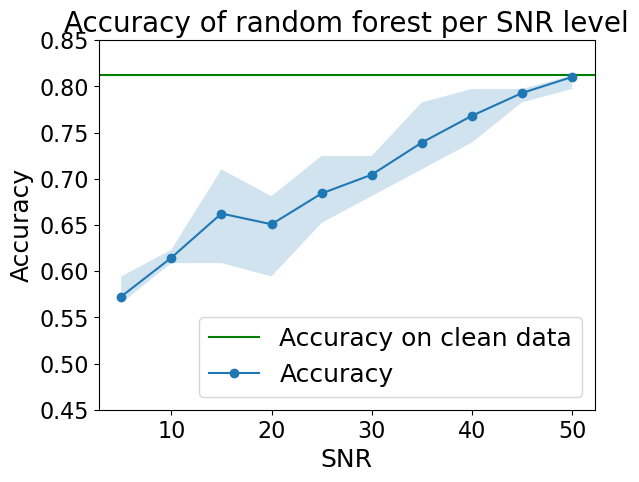

In [11]:
plt.axhline(0.812, color='green', label='Accuracy on clean data')
plt.plot(range(5, 55, 5), rf_means, label='Accuracy', marker='o')
plt.fill_between(range(5, 55, 5), rf_mins, rf_maxs, alpha=0.2)
plt.ylim(0.45, 0.85)
# plt.plot(range(5, 55, 5), rf_precs_means, label='Precision', marker='X')
# plt.fill_between(range(5, 55, 5), rf_precs_mins, rf_precs_maxs, alpha=0.2)
plt.title('Accuracy of random forest per SNR level', fontsize=20)
plt.xlabel('SNR', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

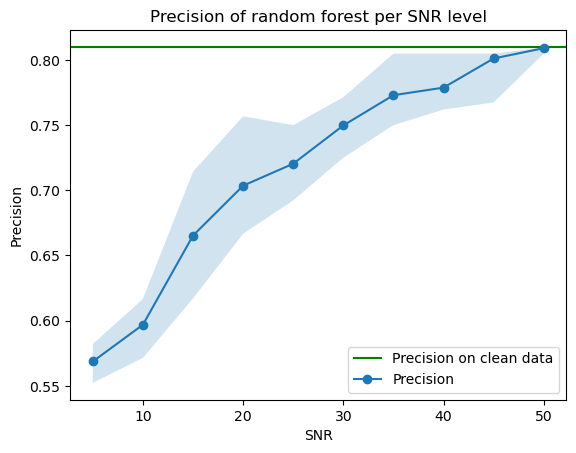

In [82]:
plt.axhline(0.810, color='green', label='Precision on clean data')
# plt.plot(range(5, 55, 5), dt_means, label='Accuracy', marker='o')
# plt.fill_between(range(5, 55, 5), dt_mins, dt_maxs, alpha=0.2)
plt.plot(range(5, 55, 5), rf_precs_means, label='Precision', marker='o')
plt.fill_between(range(5, 55, 5), rf_precs_mins, rf_precs_maxs, alpha=0.2)
plt.title('Precision of random forest per SNR level')
plt.xlabel('SNR')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

In [66]:
clf = pickle.load(open('DT2.sav', 'rb'))

In [67]:
dt_accs={}
dt_precs={}
dt_recalls={}
accs=[]
precs=[]
recalls=[]
for snr in range(5, 55, 5):
    #save noisy files
    for i in range(10):
        save_path = 'NoisyLevels//TestNoisySNR'+str(snr)+'//'
        for file in os.listdir(path):
            filename = os.fsdecode(file)
            if filename.endswith(".mp3") or filename.endswith(".wav"):
                f_id = filename.split('.')[0]
                file_type = filename.split('.')[-1]
                y, sr = librosa.load(path+filename)
                noise=np.random.normal(0, 0.1, y.shape[0])
                noise = get_noise_from_sound(y,noise,snr)
                y_noisy = y+noise

                y_noisy = preprocessing.endpoint_detection(y_noisy)
                y_noisy = preprocessing.normalization(y_noisy)

                soundfile.write(save_path+filename, y_noisy, sr)

        #extract features
        test_df = extract_feature_df(save_path) 
        test_df = test_df.drop(['Median pitch', 'Mean pitch', 'Minimum pitch', 'Maximum pitch'], axis=1)

        test_df[['RecordingID', 'RestOfName']] = test_df['name'].str.split('-',expand=True)
        test_df['Sound'] = test_df['RestOfName'].str.split('_',expand=True)[0]
        test_df['RecordingID'] = test_df['RecordingID'].astype('int')

        test_df = test_df.drop('name', axis=1)
        test_df = test_df.drop('RestOfName', axis=1)
        test_df = test_df.reset_index(drop=True)

        test_df = pd.merge(test_df, test_meta, how='left', on = 'RecordingID')

        X_test = test_df.drop(['RecordingID', 'Sound', 'Type', 'Date', 'SubjectID', 'Sex', 'Age', 'Pathology'], axis=1)
        y_test = test_df['Type']
        X_test = X_test.dropna()
        df_index = X_test.index.values.tolist()
        y_test = y_test.iloc[df_index]

        #evaluate on test 
        results = test_df[['RecordingID', 'Sound', 'Type', 'Date', 'SubjectID', 'Sex', 'Age', 'Pathology']].copy()
        results, _, _, _ = EvaluateModel.rec_results(clf, X_test, y_test, results)
        acc = metrics.accuracy_score(results['Type'], results['Pred'])
        prec = metrics.precision_score(results['Type'], results['Pred'], pos_label='p')
        recall = metrics.recall_score(results['Type'], results['Pred'], pos_label='p')
        accs.append(acc)
        precs.append(prec)
        recalls.append(recall)
        
    dt_accs[snr]=accs
    dt_precs[snr]=precs
    dt_recalls[snr]=recalls
    accs=[]
    precs=[]
    recalls=[]

In [71]:
dt_means=[]
dt_mins=[]
dt_maxs=[]
for lst in dt_results.values():
    dt_means.append(sum(lst)/len(lst))
    dt_mins.append(min(lst))
    dt_maxs.append(max(lst))

In [72]:
dt_precs_means=[]
dt_precs_mins=[]
dt_precs_maxs=[]
for lst in dt_precs.values():
    dt_precs_means.append(sum(lst)/len(lst))
    dt_precs_mins.append(min(lst))
    dt_precs_maxs.append(max(lst))

In [73]:
dt_recalls_means=[]
dt_recalls_mins=[]
dt_recalls_maxs=[]
for lst in dt_recalls.values():
    dt_recalls_means.append(sum(lst)/len(lst))
    dt_recalls_mins.append(min(lst))
    dt_recalls_maxs.append(max(lst))

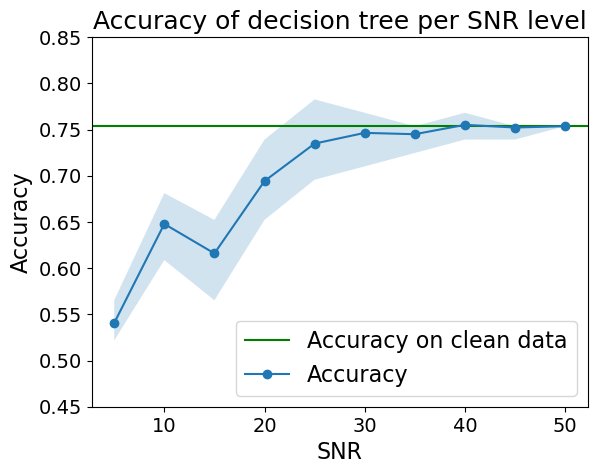

In [110]:
plt.axhline(0.754, color='green', label='Accuracy on clean data')
plt.plot(range(5, 55, 5), dt_means, label='Accuracy', marker='o')
plt.fill_between(range(5, 55, 5), dt_mins, dt_maxs, alpha=0.2)
plt.ylim(0.45, 0.85)
# plt.plot(range(5, 55, 5), dt_precs_means, label='Precision', marker='X')
# plt.fill_between(range(5, 55, 5), dt_precs_mins, dt_precs_maxs, alpha=0.2)
plt.title('Accuracy of decision tree per SNR level', fontsize=18)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc='lower right', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

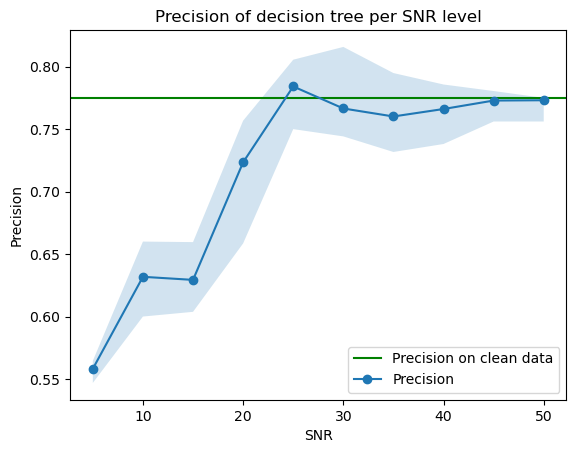

In [81]:
plt.axhline(0.775, color='green', label='Precision on clean data')
# plt.plot(range(5, 55, 5), dt_means, label='Accuracy', marker='o')
# plt.fill_between(range(5, 55, 5), dt_mins, dt_maxs, alpha=0.2)
plt.plot(range(5, 55, 5), dt_precs_means, label='Precision', marker='o')
plt.fill_between(range(5, 55, 5), dt_precs_mins, dt_precs_maxs, alpha=0.2)
plt.title('Precision of decision tree per SNR level')
plt.xlabel('SNR')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

In [83]:
clf = pickle.load(open('SVM2.sav', 'rb'))

In [84]:
svm_accs={}
svm_precs={}
svm_recalls={}
accs=[]
precs=[]
recalls=[]
for snr in range(5, 55, 5):
    #save noisy files
    for i in range(10):
        save_path = 'NoisyLevels//TestNoisySNR'+str(snr)+'//'
        for file in os.listdir(path):
            filename = os.fsdecode(file)
            if filename.endswith(".mp3") or filename.endswith(".wav"):
                f_id = filename.split('.')[0]
                file_type = filename.split('.')[-1]
                y, sr = librosa.load(path+filename)
                noise=np.random.normal(0, 0.1, y.shape[0])
                noise = get_noise_from_sound(y,noise,snr)
                y_noisy = y+noise

                y_noisy = preprocessing.endpoint_detection(y_noisy)
                y_noisy = preprocessing.normalization(y_noisy)

                soundfile.write(save_path+filename, y_noisy, sr)

        #extract features
        test_df = extract_feature_df(save_path) 
        test_df = test_df.drop(['Median pitch', 'Mean pitch', 'Minimum pitch', 'Maximum pitch'], axis=1)

        test_df[['RecordingID', 'RestOfName']] = test_df['name'].str.split('-',expand=True)
        test_df['Sound'] = test_df['RestOfName'].str.split('_',expand=True)[0]
        test_df['RecordingID'] = test_df['RecordingID'].astype('int')

        test_df = test_df.drop('name', axis=1)
        test_df = test_df.drop('RestOfName', axis=1)
        test_df = test_df.reset_index(drop=True)

        test_df = pd.merge(test_df, test_meta, how='left', on = 'RecordingID')

        X_test = test_df.drop(['RecordingID', 'Sound', 'Type', 'Date', 'SubjectID', 'Sex', 'Age', 'Pathology'], axis=1)
        y_test = test_df['Type']
        X_test = X_test.dropna()
        df_index = X_test.index.values.tolist()
        y_test = y_test.iloc[df_index]

        #evaluate on test 
        results = test_df[['RecordingID', 'Sound', 'Type', 'Date', 'SubjectID', 'Sex', 'Age', 'Pathology']].copy()
        results, _, _, _ = EvaluateModel.rec_results(clf, X_test, y_test, results)
        acc = metrics.accuracy_score(results['Type'], results['Pred'])
        prec = metrics.precision_score(results['Type'], results['Pred'], pos_label='p')
        recall = metrics.recall_score(results['Type'], results['Pred'], pos_label='p')
        accs.append(acc)
        precs.append(prec)
        recalls.append(recall)
        
    svm_accs[snr]=accs
    svm_precs[snr]=precs
    svm_recalls[snr]=recalls
    accs=[]
    precs=[]
    recalls=[]

In [85]:
svm_means=[]
svm_mins=[]
svm_maxs=[]
for lst in svm_results.values():
    svm_means.append(sum(lst)/len(lst))
    svm_mins.append(min(lst))
    svm_maxs.append(max(lst))

In [86]:
svm_precs_means=[]
svm_precs_mins=[]
svm_precs_maxs=[]
for lst in svm_precs.values():
    svm_precs_means.append(sum(lst)/len(lst))
    svm_precs_mins.append(min(lst))
    svm_precs_maxs.append(max(lst))

In [87]:
svm_recalls_means=[]
svm_recalls_mins=[]
svm_recalls_maxs=[]
for lst in svm_recalls.values():
    svm_recalls_means.append(sum(lst)/len(lst))
    svm_recalls_mins.append(min(lst))
    svm_recalls_maxs.append(max(lst))

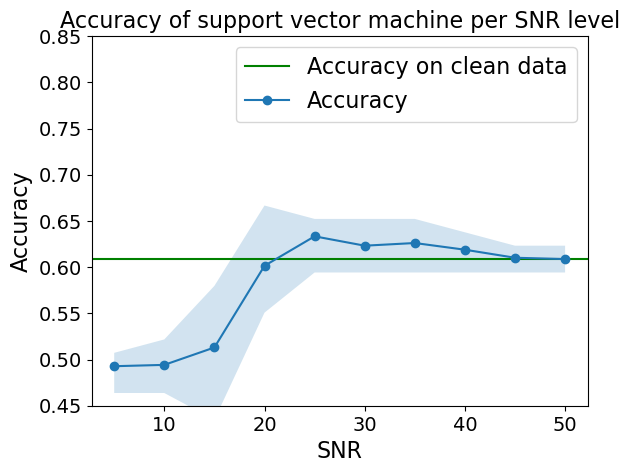

In [114]:
plt.axhline(0.609, color='green', label='Accuracy on clean data')
plt.plot(range(5, 55, 5), svm_means, label='Accuracy', marker='o')
plt.fill_between(range(5, 55, 5), svm_mins, svm_maxs, alpha=0.2)
plt.ylim(0.45, 0.850)
# plt.plot(range(5, 55, 5), dt_precs_means, label='Precision', marker='X')
# plt.fill_between(range(5, 55, 5), dt_precs_mins, dt_precs_maxs, alpha=0.2)
plt.title('Accuracy of support vector machine per SNR level', fontsize=16)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

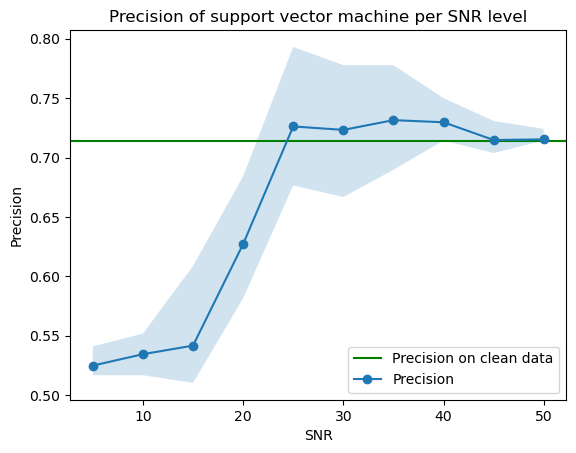

In [89]:
plt.axhline(0.714, color='green', label='Precision on clean data')
# plt.plot(range(5, 55, 5), dt_means, label='Accuracy', marker='o')
# plt.fill_between(range(5, 55, 5), dt_mins, dt_maxs, alpha=0.2)
plt.plot(range(5, 55, 5), svm_precs_means, label='Precision', marker='o')
plt.fill_between(range(5, 55, 5), svm_precs_mins, svm_precs_maxs, alpha=0.2)
plt.title('Precision of support vector machine per SNR level')
plt.xlabel('SNR')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

In [90]:
clf = pickle.load(open('LR2.sav', 'rb'))

In [91]:
lr_accs={}
lr_precs={}
lr_recalls={}
accs=[]
precs=[]
recalls=[]
for snr in range(5, 55, 5):
    #save noisy files
    for i in range(10):
        save_path = 'NoisyLevels//TestNoisySNR'+str(snr)+'//'
        for file in os.listdir(path):
            filename = os.fsdecode(file)
            if filename.endswith(".mp3") or filename.endswith(".wav"):
                f_id = filename.split('.')[0]
                file_type = filename.split('.')[-1]
                y, sr = librosa.load(path+filename)
                noise=np.random.normal(0, 0.1, y.shape[0])
                noise = get_noise_from_sound(y,noise,snr)
                y_noisy = y+noise

                y_noisy = preprocessing.endpoint_detection(y_noisy)
                y_noisy = preprocessing.normalization(y_noisy)

                soundfile.write(save_path+filename, y_noisy, sr)

        #extract features
        test_df = extract_feature_df(save_path) 
        test_df = test_df.drop(['Median pitch', 'Mean pitch', 'Minimum pitch', 'Maximum pitch'], axis=1)

        test_df[['RecordingID', 'RestOfName']] = test_df['name'].str.split('-',expand=True)
        test_df['Sound'] = test_df['RestOfName'].str.split('_',expand=True)[0]
        test_df['RecordingID'] = test_df['RecordingID'].astype('int')

        test_df = test_df.drop('name', axis=1)
        test_df = test_df.drop('RestOfName', axis=1)
        test_df = test_df.reset_index(drop=True)

        test_df = pd.merge(test_df, test_meta, how='left', on = 'RecordingID')

        X_test = test_df.drop(['RecordingID', 'Sound', 'Type', 'Date', 'SubjectID', 'Sex', 'Age', 'Pathology'], axis=1)
        y_test = test_df['Type']
        X_test = X_test.dropna()
        df_index = X_test.index.values.tolist()
        y_test = y_test.iloc[df_index]

        #evaluate on test 
        results = test_df[['RecordingID', 'Sound', 'Type', 'Date', 'SubjectID', 'Sex', 'Age', 'Pathology']].copy()
        results, _, _, _ = EvaluateModel.rec_results(clf, X_test, y_test, results)
        acc = metrics.accuracy_score(results['Type'], results['Pred'])
        prec = metrics.precision_score(results['Type'], results['Pred'], pos_label='p')
        recall = metrics.recall_score(results['Type'], results['Pred'], pos_label='p')
        accs.append(acc)
        precs.append(prec)
        recalls.append(recall)
        
    lr_accs[snr]=accs
    lr_precs[snr]=precs
    lr_recalls[snr]=recalls
    accs=[]
    precs=[]
    recalls=[]

In [92]:
lr_means=[]
lr_mins=[]
lr_maxs=[]
for lst in lr_results.values():
    lr_means.append(sum(lst)/len(lst))
    lr_mins.append(min(lst))
    lr_maxs.append(max(lst))

In [94]:
lr_precs_means=[]
lr_precs_mins=[]
lr_precs_maxs=[]
for lst in lr_precs.values():
    lr_precs_means.append(sum(lst)/len(lst))
    lr_precs_mins.append(min(lst))
    lr_precs_maxs.append(max(lst))

In [95]:
lr_recalls_means=[]
lr_recalls_mins=[]
lr_recalls_maxs=[]
for lst in lr_recalls.values():
    lr_recalls_means.append(sum(lst)/len(lst))
    lr_recalls_mins.append(min(lst))
    lr_recalls_maxs.append(max(lst))

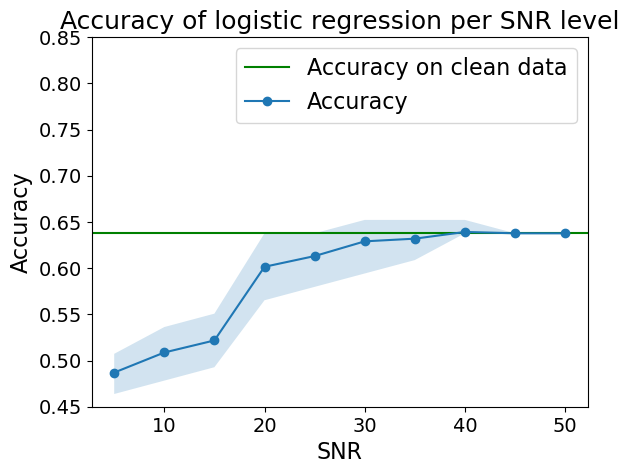

In [115]:
plt.axhline(0.638, color='green', label='Accuracy on clean data')
plt.plot(range(5, 55, 5), lr_means, label='Accuracy', marker='o')
plt.fill_between(range(5, 55, 5), lr_mins, lr_maxs, alpha=0.2)
plt.ylim(0.45, 0.85)
# plt.plot(range(5, 55, 5), dt_precs_means, label='Precision', marker='X')
# plt.fill_between(range(5, 55, 5), dt_precs_mins, dt_precs_maxs, alpha=0.2)
plt.title('Accuracy of logistic regression per SNR level', fontsize=18)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

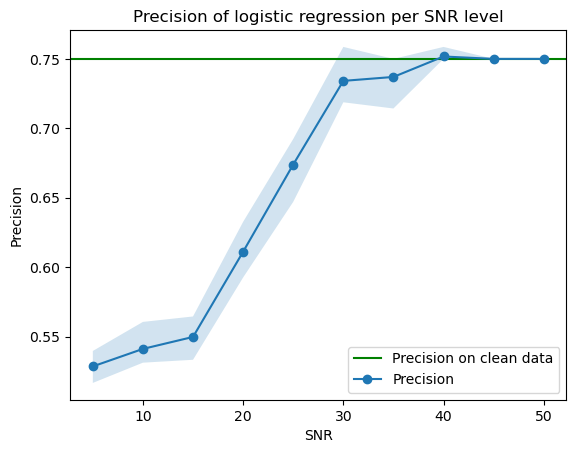

In [97]:
plt.axhline(0.750, color='green', label='Precision on clean data')
# plt.plot(range(5, 55, 5), dt_means, label='Accuracy', marker='o')
# plt.fill_between(range(5, 55, 5), dt_mins, dt_maxs, alpha=0.2)
plt.plot(range(5, 55, 5), lr_precs_means, label='Precision', marker='o')
plt.fill_between(range(5, 55, 5), lr_precs_mins, lr_precs_maxs, alpha=0.2)
plt.title('Precision of logistic regression per SNR level')
plt.xlabel('SNR')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()